In [1]:
# Import necessary tools
import tensorflow as tf
import tensorflow_hub as hub 
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.9.2
TF Hub version: 0.12.0
GPU available (YESSSS!!!!!)


## Getting our data ready (turning into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first. Turning our images into Tensors (numerical representations).

Let's start by accessing our data and checking out the labels.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DATA_PATH = "drive/MyDrive/Colab Notebooks/data/dog-vision"
# "drive/My Drive/Dog Vision"

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv(f"{DATA_PATH}/labels.csv")

### Getting images and their labels 

Let's get a list of all of our image file pathnames.

In [5]:
# Create pathnames from imageID's
filenames = [f"{DATA_PATH}/train/{fname}.jpg" for fname in labels_csv["id"]]

In [6]:
# Check weather number of filenames matches number of actual image files
import os
if len(os.listdir(f"{DATA_PATH}/train/")) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print("Filenames do no match actual amount of files, check the target directory.")

Filenames match actual amount of files!!! Proceed.


Since we've now got our training image filepaths in a list, let's prepare our labels

In [7]:
import numpy as np
labels = labels_csv["breed"].to_numpy() 
# labels = np.array(labels) # does same thing as above
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [8]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [9]:
# Find the unique label values
unique_breeds = np.unique(labels)

# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

### Creating our own validation set
Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [10]:
# Setup X & y variables
X = filenames
y = boolean_labels

## Preprocessing Images (turning images into Tensors)

To preprocess our images into Tensors we're going to write a function which does a few things:
1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Normalize our image (convert color channel values from 0-255 to 0-1).
5. Resize the `image` to be a shape of (224, 224)
6. Return the modified `image`

Before we do, let's see what importing an image looks like.

In [11]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning our data into batches

Why turn our data into batches?

Let's say you're trying to process 10,000+ images in one go... they all might not fit into memory.

So that's why we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size if need be).

In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: 
`(image, label)`.

In [12]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the assosciated label,
  processes the image and reutrns a typle of (image, label).
  """
  image = process_image(image_path)
  return image, label

Now we've got a way to turn our data into tuples of Tensors in the form: `(image, label)`, let's make a function to turn all of our data (`X` & `y`) into batches!

In [13]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(batch_size)
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(batch_size)

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(batch_size)
  return data_batch

In [14]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

In [15]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

Now since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and then compare those predictions to the validation labels (truth labels).

In [16]:
# Create a function to unbatch a batch dataset
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and reutrns separate arrays
  of images and labels.
  """
  images = []
  labels = []
  # Loop through unbatched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images, labels

Now we've got ways to get get:
* Prediction labels
* Validation labels (truth labels)
* Validation images

Let's make some function to make these all a bit more visaulize.

We'll create a function which:
* Takes an array of prediction probabilities, an array of truth labels and an array of images and an integer. ✅
* Convert the prediction probabilities to a predicted label. ✅
* Plot the predicted label, its predicted probability, the truth label and the target image on a single plot. ✅

In [17]:
import matplotlib.pyplot as plt

def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  
  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

Now we've got one function to visualize our models top prediction, let's make another to view our models top 10 predictions.

This function will:
* Take an input of prediction probabilities array and a ground truth array and an integer ✅
* Find the prediction using `get_pred_label()` ✅
* Find the top 10:
  * Prediction probabilities indexes ✅
  * Prediction probabilities values ✅
  * Prediction labels ✅
* Plot the top 10 prediction probability values and labels, coloring the true label green ✅

In [18]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plus the top 10 highest prediction confidences along with the truth label for sample n.
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top 10 prediction confidence indexes
  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  # Find the top 10 prediction confidence values
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  # Find the top 10 prediction labels
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")
  
  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

Now we've got some function to help us visualize our predictions and evaluate our modle, let's check out a few.

In [19]:
# Let's check out a few predictions and their different values
def plot_pred_combine(prediction_probabilities, labels, images, i_multiplier=0, num_rows=3, num_cols=2):
  num_images = num_rows*num_cols
  plt.figure(figsize=(10*num_cols, 5*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities=prediction_probabilities,
              labels=labels,
              images=images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities=prediction_probabilities,
                  labels=labels,
                  n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)
  plt.show()

In [20]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

---

In [21]:
# Load a trained model
full_model = load_model(f"{DATA_PATH}/models/20230201-21551675288518-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/MyDrive/Colab Notebooks/data/dog-vision/models/20230201-21551675288518-full-image-set-mobilenetv2-Adam.h5


In [22]:
# Load predictions (NumPy array) from csv file
test_predictions = np.loadtxt(f"{DATA_PATH}/preds_array.csv", delimiter=",")

---

In [23]:
# Load test image file names
TEST_PATH = f"{DATA_PATH}/test/"

## Making predictions on custom images

To make predictions on custom images, we'll:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the predicted labels to the custom images.

In [24]:
# Get custom image filepaths
CUSTOM_PATH = f"{DATA_PATH}/my-dog-photos/"
custom_image_paths = [CUSTOM_PATH + fname for fname in os.listdir(CUSTOM_PATH)]

In [25]:
custom_image_paths

['drive/MyDrive/Colab Notebooks/data/dog-vision/my-dog-photos/emily-2.jpeg',
 'drive/MyDrive/Colab Notebooks/data/dog-vision/my-dog-photos/melanie-3.jpg',
 'drive/MyDrive/Colab Notebooks/data/dog-vision/my-dog-photos/emily-1.jpg',
 'drive/MyDrive/Colab Notebooks/data/dog-vision/my-dog-photos/melanie-2.jpg',
 'drive/MyDrive/Colab Notebooks/data/dog-vision/my-dog-photos/melanie-1.jpg']

In [26]:
# Turn custom images into batch datasets 
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [27]:
# Make predictions on the custom data
custom_preds = full_model.predict(custom_data)

1/1 [==============================] - 8s 8s/step


In [28]:
custom_preds.shape

(5, 120)

In [29]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['toy_poodle',
 'staffordshire_bullterrier',
 'toy_terrier',
 'labrador_retriever',
 'lakeland_terrier']

In [30]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

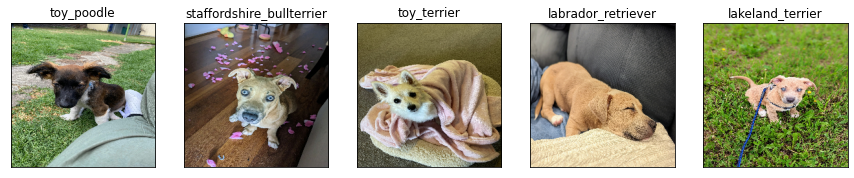

In [31]:
# Check custom image predictions
len_images = len(custom_images)
plt.figure(figsize=(len_images*3, len_images*3))
for i, image in enumerate(custom_images):
  plt.subplot(1, len_images, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

In [32]:
import matplotlib.pyplot as plt

def plot_pred_custom(prediction_probabilities, images, labels=None, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob = prediction_probabilities[n]
  true_label = "" if labels is None else labels[n]
  image = images[n]

  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  # Plot image & remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])
  
  # Change the colour of the title depending on if the prediction is right or wrong
  if true_label == "":
    color = "black"
  elif pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

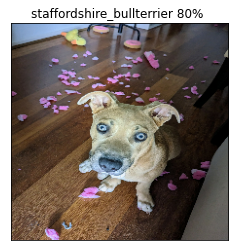

In [33]:
plot_pred_custom(prediction_probabilities=custom_preds,
          images=custom_images)

In [34]:
def plot_pred_conf_custom(prediction_probabilities, labels=None, n=1, rank_count=5):
  """
  Plus the top prediction confidences along with the truth label for sample n.
  """
  pred_prob = prediction_probabilities[n]
  true_label = "" if labels is None else labels[n]

  # Get the predicted label
  pred_label = get_pred_label(pred_prob)

  # Find the top (rank_count) prediction confidence indexes
  top_pred_indexes = pred_prob.argsort()[-rank_count:][::-1]
  # Find the top (rank_count) prediction confidence values
  top_pred_values = (pred_prob[top_pred_indexes] * 100).round(2)
  # Find the top (rank_count) prediction labels
  # top_pred_labels = unique_breeds[top_pred_indexes] + "\n" + "{:2.0f}".format(top_pred_values*100)
  top_pred_labels = unique_breeds[top_pred_indexes] + "\n" + top_pred_values.astype(str) + "%"

  # Setup plot version 1
  top_plot = plt.bar(np.arange(len(top_pred_labels)),
                     top_pred_values,
                     color="grey")
  plt.xticks(np.arange(len(top_pred_labels)),
             labels=top_pred_labels,
             rotation=60)

  # # Setup plot version 2
  # fig, ax = plt.subplots(figsize=(5, 3))
  # # Plot the data
  # bar = ax.bar(np.arange(len(top_pred_labels)),
  #              top_pred_values,
  #              color="grey")
  # # Xticks
  # ax.set_xticks(np.arange(len(top_pred_labels)))
  # ax.set_xticklabels(top_pred_labels,
  #                    rotation=60)
  # # Customize the plot
  # ax.set(title="What's your dog's breed?",
  #        ylabel="prediction (%)")

  # Change color of true label
  # if np.isin(true_label, top_pred_labels):
  #   top_plot[np.argmax(top_pred_labels == true_label)].set_color("green")
  # else:
  #   pass

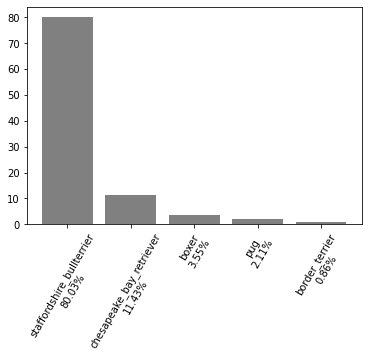

In [35]:
plot_pred_conf_custom(prediction_probabilities=custom_preds)

In [36]:
# Let's check out a few predictions and their different values
def plot_pred_combine_custom(prediction_probabilities, images, labels=None, i_multiplier=0, num_rows=3, num_cols=2):
  num_images = min(num_rows*num_cols, len(prediction_probabilities))
  plt.figure(figsize=(10*num_cols, 5*num_rows))
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred_custom(prediction_probabilities=prediction_probabilities,
              labels=labels,
              images=images,
              n=i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf_custom(prediction_probabilities=prediction_probabilities,
                  labels=labels,
                  n=i+i_multiplier)
  plt.tight_layout(h_pad=1.0)
  plt.show()

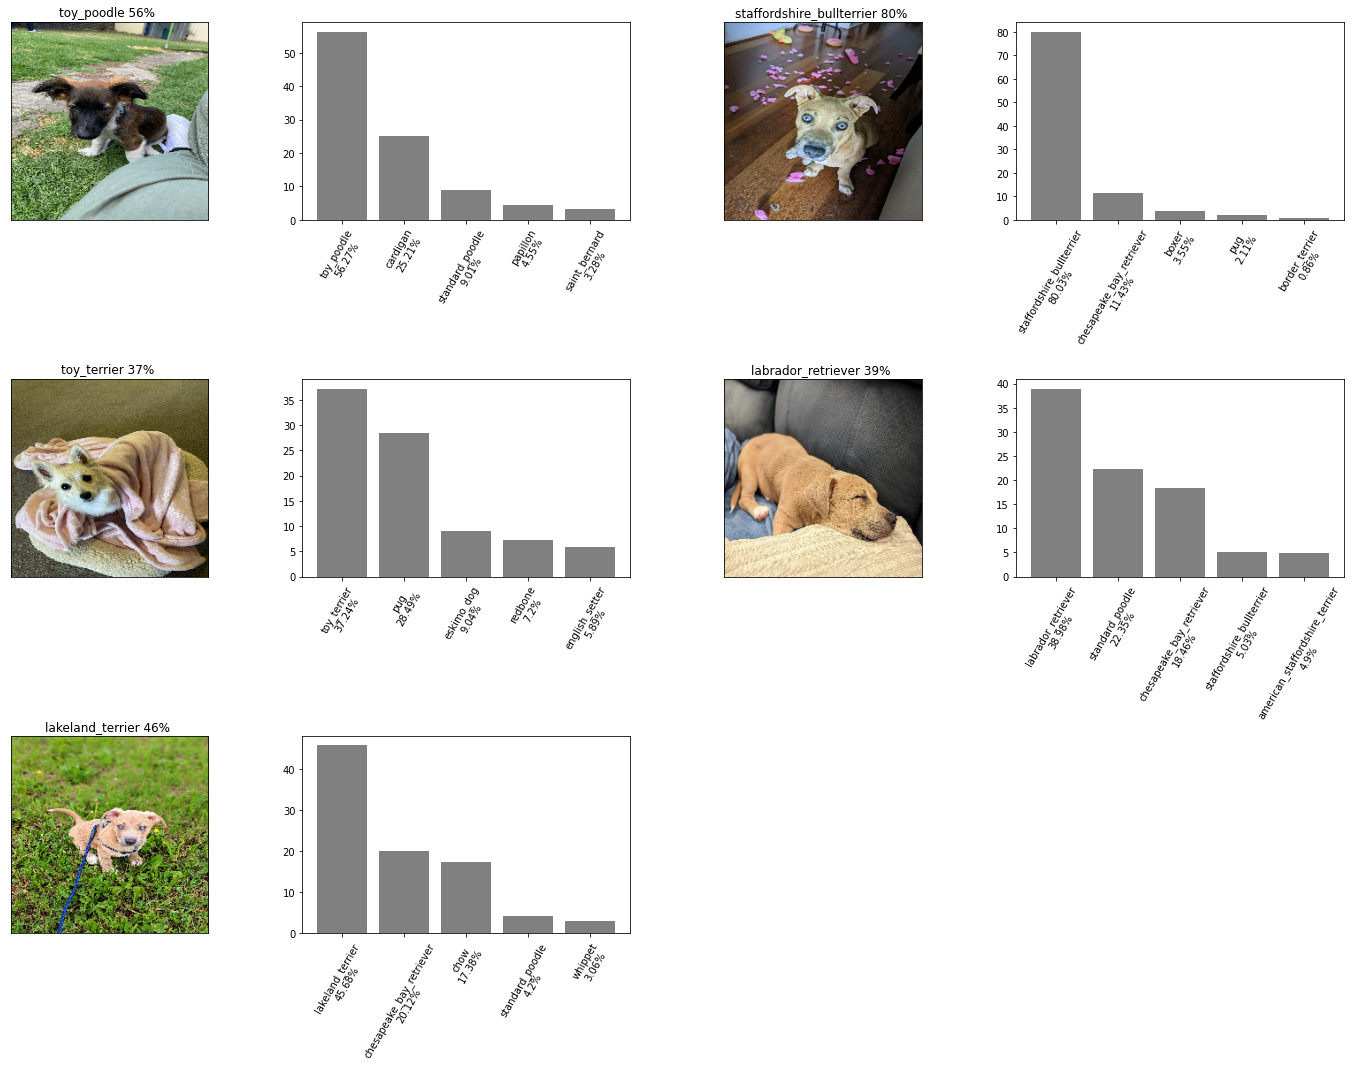

In [37]:
plot_pred_combine_custom(prediction_probabilities=custom_preds,
                         images=custom_images,
                         i_multiplier=0)